<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Dynamic Double Machine Learning: Use Cases and Examples

Dynamic DoubleML is an extension of the Double ML approach for treatments assigned sequentially over time periods. This estimator will account for treatments that can have causal effects on future outcomes. For more details, see [this paper](https://arxiv.org/abs/2002.07285) or the [EconML docummentation](https://econml.azurewebsites.net/).

For example, the Dynamic DoubleML could be useful in estimating the following causal effects:
* the effect of investments on revenue at companies that receive investments at regular intervals ([see more](https://arxiv.org/abs/2103.08390))
* the effect of prices on demand in stores where prices of goods change over time
* the effect of income on health outcomes in people who receive yearly income

The preferred data format is balanced panel data. Each panel corresponds to one entity (e.g. company, store or person) and the different rows in a panel correspond to different time points. Example:

||Company|Year|Features|Investment|Revenue|
|---|---|---|---|---|---|
|1|A|2018|...|\$1,000|\$10,000|
|2|A|2019|...|\$2,000|\$12,000|
|3|A|2020|...|\$3,000|\$15,000|
|4|B|2018|...|\$0|\$5,000|
|5|B|2019|...|\$100|\$10,000|
|6|B|2020|...|\$1,200|\$7,000|
|7|C|2018|...|\$1,000|\$20,000|
|8|C|2019|...|\$1,500|\$25,000|
|9|C|2020|...|\$500|\$15,000|

(Note: when passing the data to the DynamicDML estimator, the "Company" column above corresponds to the `groups` argument at fit time. The "Year" column above should not be passed in as it will be inferred from the "Company" column)

If group memebers do not appear together, it is assumed that the first instance of a group in the dataset corresponds to the first period of that group, the second instance of the group corresponds to the second period, etc. Example:

||Company|Features|Investment|Revenue|
|---|---|---|---|---|
|1|A|...|\$1,000|\$10,000|
|2|B|...|\$0|\$5,000
|3|C|...|\$1,000|\$20,000|
|4|A|...|\$2,000|\$12,000|
|5|B|...|\$100|\$10,000|
|6|C|...|\$1,500|\$25,000|
|7|A|...|\$3,000|\$15,000|
|8|B|...|\$1,200|\$7,000|
|9|C|...|\$500|\$15,000|

In this dataset, 1<sup>st</sup> row corresponds to the first period of group `A`, 4<sup>th</sup> row corresponds to the second period of group `A`, etc.

In this notebook, we show the performance of the DynamicDML on synthetic and observational data. 

## Notebook Contents

1. [Example Usage with Average Treatment Effects](#1.-Example-Usage-with-Average-Treatment-Effects)
2. [Example Usage with Heterogeneous Treatment Effects](#2.-Example-Usage-with-Heterogeneous-Treatment-Effects)

In [1]:
import econml

In [2]:
# Main imports
from econml.dml import DynamicDML
from econml.tests.dgp import DynamicPanelDGP

# Helper imports
import numpy as np
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, MultiTaskLassoCV
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Example Usage with Average Treatment Effects

## 1.1 DGP

We consider a data generating process from a markovian treatment model. 

In the example bellow, $T_t\rightarrow$ treatment(s) at time $t$, $Y_t\rightarrow$outcome at time $t$, $X_t\rightarrow$ features and controls at time $t$ (the coefficients $e, f'$ will pick the features and the controls).
\begin{align}
    X_t =& (\pi'X_{t-1} + 1) \cdot A\, T_{t-1} + B X_{t-1} + \epsilon_t\\
    T_t =& \gamma\, T_{t-1} + (1-\gamma) \cdot D X_t + \zeta_t\\
    Y_t =& (\sigma' X_{t} + 1) \cdot e\, T_{t} + f X_t + \eta_t
\end{align}

with $X_0, T_0 = 0$ and $\epsilon_t, \zeta_t, \eta_t \sim N(0, \sigma^2)$. Moreover, $X_t \in R^{n_x}$, $B[:, 0:s_x] \neq 0$ and $B[:, s_x:-1] = 0$, $\gamma\in [0, 1]$, $D[:, 0:s_x] \neq 0$, $D[:, s_x:-1]=0$, $f[0:s_x]\neq 0$, $f[s_x:-1]=0$. We draw a single time series of samples of length $n\_panels \cdot n\_periods$.

In [3]:
# Define DGP parameters
np.random.seed(123)
n_panels = 1000 # number of panels
n_periods = 3 # number of time periods in each panel
n_treatments = 1 # number of treatments in each period
n_x = 100 # number of features + controls
s_x = 10 # number of controls (endogeneous variables)
s_t = 10 # treatment support size

In [4]:
# Generate data
dgp = DynamicPanelDGP(n_periods, n_treatments, n_x).create_instance(
            s_x, random_seed=12345)
Y, T, X, W, groups = dgp.observational_data(n_panels, s_t=s_t, random_seed=12345)
true_effect = dgp.true_effect

## 1.2 Train Estimator

In [5]:
est = DynamicDML(
    model_y=LassoCV(cv=3), 
    model_t=MultiTaskLassoCV(cv=3), 
    cv=3)

In [6]:
est.fit(Y, T, X=None, W=W, groups=groups, inference="auto")

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0609523330807065, tolerance: 0.3973271492025328


In [7]:
# Average treatment effect of all periods on last period for unit treatments
print(f"Average effect of default policy: {est.ate():0.2f}")

Average effect of default policy: 2.35


In [8]:
# Effect of target policy over baseline policy
# Must specify a treatment for each period
baseline_policy = np.zeros((1, n_periods))
target_policy = np.array([[1, 2, 3]])
eff = est.effect(T0=baseline_policy, T1=target_policy)
print(f"Effect of target policy over baseline policy: {eff[0]:0.2f}")

Effect of target policy over baseline policy: 4.79


In [9]:
# Period treatment effects + interpretation
for i, theta in enumerate(est.intercept_):
    print(f"Effect of a treatment in period {i+1} on period {n_periods} outcome: {theta:0.2f}")

Effect of a treatment in period 1 on period 3 outcome: 0.61
Effect of a treatment in period 2 on period 3 outcome: 1.05
Effect of a treatment in period 3 on period 3 outcome: 0.69


In [10]:
# Period treatment effects with confidence intervals
est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|(T0)$_0$,0.61,0.09,6.74,0.0,0.461,0.758
cate_intercept|(T0)$_1$,1.05,0.067,15.565,0.0,0.939,1.161
cate_intercept|(T0)$_2$,0.692,0.031,22.308,0.0,0.641,0.743


In [11]:
conf_ints = est.intercept__interval(alpha=0.05)

## 1.3 Performance Visualization

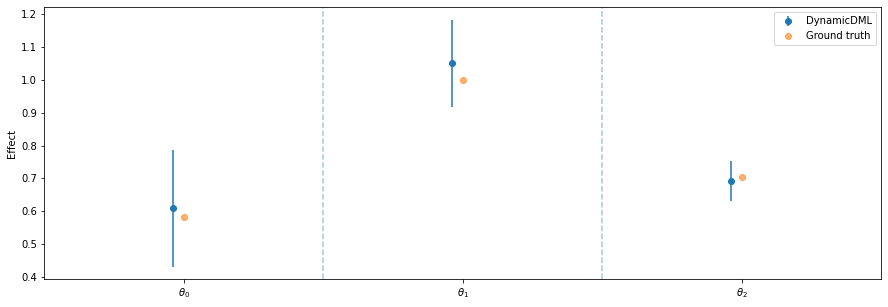

In [12]:
# Some plotting boilerplate code
plt.figure(figsize=(15, 5))
plt.errorbar(np.arange(n_periods*n_treatments)-.04, est.intercept_, yerr=(conf_ints[1] - est.intercept_,
                                                    est.intercept_ - conf_ints[0]), fmt='o', label='DynamicDML')
plt.errorbar(np.arange(n_periods*n_treatments), true_effect.flatten(), fmt='o', alpha=.6, label='Ground truth')
for t in np.arange(1, n_periods):
    plt.axvline(x=t * n_treatments - .5, linestyle='--', alpha=.4)
plt.xticks([t * n_treatments - .5 + n_treatments/2 for t in range(n_periods)],
           ["$\\theta_{}$".format(t) for t in range(n_periods)])
plt.gca().set_xlim([-.5, n_periods*n_treatments - .5])
plt.ylabel("Effect")
plt.legend()
plt.show()

# 2. Example Usage with Heterogeneous Treatment Effects

## 2.1 DGP

In [13]:
# Define additional DGP parameters
het_strength = .5
het_inds = np.arange(n_x - n_treatments, n_x)

In [14]:
# Generate data
dgp = DynamicPanelDGP(n_periods, n_treatments, n_x).create_instance(
            s_x, hetero_strength=het_strength, hetero_inds=het_inds, random_seed=12)
Y, T, X, W, groups = dgp.observational_data(n_panels, s_t=s_t, random_seed=1)
ate_effect = dgp.true_effect
het_effect = dgp.true_hetero_effect[:, het_inds + 1]

## 2.2 Train Estimator

In [15]:
est = DynamicDML(
    model_y=LassoCV(cv=3), 
    model_t=MultiTaskLassoCV(cv=3), 
    cv=3)

In [16]:
est.fit(Y, T, X=X, W=W, groups=groups, inference="auto")

In [17]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0|(T0)$_0$,0.115,0.119,0.968,0.333,-0.081,0.311
X0|(T0)$_1$,-0.041,0.12,-0.339,0.735,-0.239,0.157
X0|(T0)$_2$,0.392,0.073,5.366,0.0,0.272,0.512
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|(T0)$_0$,-0.085,0.06,-1.411,0.158,-0.184,0.014
cate_intercept|(T0)$_1$,-0.027,0.059,-0.462,0.644,-0.125,0.07
cate_intercept|(T0)$_2$,0.602,0.034,17.813,0.0,0.547,0.658


In [18]:
# Average treatment effect for test points
X_test = X[:10]
print(f"Average effect of default policy:{est.ate(X=X_test):0.2f}")

Average effect of default policy:0.45


In [19]:
# Effect of target policy over baseline policy
# Must specify a treatment for each period
baseline_policy = np.zeros((1, n_periods))
target_policy = np.array([[1, 2, 3]])
eff = est.effect(X=X_test, T0=baseline_policy, T1=target_policy)
print("Effect of target policy over baseline policy for test set:\n", eff)

Effect of target policy over baseline policy for test set:
 [2.08972181 2.23249102 1.22483907 1.72010749 1.73030869 2.56658993
 0.27482914 1.10741935 2.00298489 0.75833676]


In [20]:
# Coefficients
est.intercept_, est.coef_

(array([-0.08491363, -0.02731669,  0.60246595]),
 array([[ 0.11529833],
        [-0.04079943],
        [ 0.39168147]]))

In [21]:
# Confidence intervals
conf_ints_intercept = est.intercept__interval(alpha=0.05)
conf_ints_coef = est.coef__interval(alpha=0.05)

## 2.3 Performance Visualization

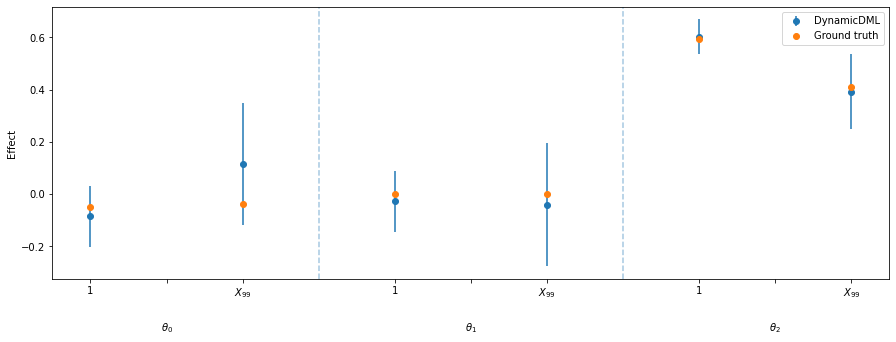

In [22]:
# Some plotting boilerplate code
plt.figure(figsize=(15, 5))
# Intercepts
plt.errorbar((het_inds.shape[0]+1)*np.arange(n_periods*n_treatments), 
             est.intercept_, 
             yerr=(conf_ints_intercept[1] - est.intercept_, est.intercept_ - conf_ints_intercept[0]), 
             fmt='o', label='DynamicDML')
plt.errorbar((het_inds.shape[0]+1)*np.arange(n_periods*n_treatments), ate_effect.flatten(), 
             fmt='o', label='Ground truth')
# Heterogeneous effects
plt.errorbar((het_inds.shape[0]+1)*np.arange(n_periods*n_treatments)+1, est.coef_, 
             yerr=((conf_ints_coef[1] - est.coef_).flatten(), 
                   (est.coef_ - conf_ints_coef[0]).flatten()), 
             fmt='o', color='C0')
plt.errorbar((het_inds.shape[0]+1)*np.arange(n_periods*n_treatments)+1, het_effect, 
             fmt='o', color='C1')
for t in np.arange(2, (het_inds.shape[0]+1)*n_periods, 2):
    plt.axvline(x=t * n_treatments - .5, linestyle='--', alpha=.4)
# Labels
x_range = np.arange(n_periods*n_treatments*(het_inds.shape[0]+1))
x_ticks = list(x_range)
x_labels = [1 if i%(n_treatments+1)==0 else f"$X_\u007b{het_inds[i%(n_treatments+1)-1]}\u007d$" for i in x_range]
x_ticks += [het_inds.shape[0]/2 + i*(n_treatments*(het_inds.shape[0]+1)) for i in range(n_periods)]
x_labels += [f"\n\n\n$\\theta_{i}$" for i in range(n_periods)]
plt.xticks(x_ticks, x_labels)
plt.ylabel("Effect")
plt.legend()
plt.show()